# Introduction to Classification

In previous labs we mostly worked with regression models. We now discuss an analogous class of models for solving classification problems. Again, I will try and follow the notation in your lectures. If you enjoyed [Chris Bishop's](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) digression on regression, you may want to read through Chapter 4, which discusses classification.

The goal in classification is to take an input vector $X$ and to assign it to one of $K$ discrete classes $\mathbf{Y}_k$ where k = 1, . . . , K. Generaly, these classes are assumed to be disjoint, so that each input is assigned to one (and only one) class. The input space is thereby divided into decision regions whose boundaries are called decision boundaries or decision surfaces.

Decision surfaces are modelled as functions of the input vector $X$ and hence are defined by $D-1$-dimensional hyperplanes within the D-dimensional input space. Data sets whose classes can be separated exactly by linear decision surfaces are said to be linearly separable.



As seen in class, classification uses a function (i.e. a classifiers) $y=f(Xw)$  to map inputs $X$ to class $y$. In the machine learning literature, $f(.)$ is also know as an activation function, whereas its inverse is called a link function. Note that, in contrast to some of the models used for regression that we have discussed, this class of models is no longer linear in the parameters due to the presence of the non-linear function $f(.)$. 


The intuitive starting point is therefore to define the classifier. Let's give some practical examples of classification problems with different families of classifiers.

In today's lab, we will see several examples of classifiers using a Credit Card Fraud Detection dataset provided by Kaggle.


## K-Nearest Neighbors (K-NN)

**Basic Idea**:
K-Nearest Neighbors (K-NN) is a simple and intuitive machine learning algorithm used for both classification and regression tasks (though here we focus solely on classification problems). It works based on the idea that similar data points tend to be close to each other in a feature space. 

**K-NN step-by-step**:

1. **Pick a Value for K**: Choose the number of nearest neighbors (K) that you want to consider when making predictions.

2. **Calculate Distances**: Measure the distance between the new data point and all the data points in your dataset (eg. Euclidean distance or other measure).

3. **Find K Nearest Neighbors**: Identify the K data points from your dataset that are closest to the new data point based on the calculated distances.

4. **Majority Vote**: Look at the class labels of the K nearest neighbors and choose the class that appears most frequently (majority vote). The new data point is classified as that class.

**Example**:
Let's say you have a dataset of houses with features like square footage and number of bedrooms, and you want to predict whether a new house is "small" or "large" based on those features. If K=3, K-NN would find the 3 nearest houses to the new one and classify it based on the majority class among those 3 houses. If 2 of the 3 nearest houses are "small," the new house would also be classified as "small."

**Remarks**:

- The choice of K can affect the algorithm's performance. A smaller K (e.g. 1) can lead to noisy predictions, while a larger K can lead to overly smooth predictions.
- K-NN can be sensitive to the scale of your data, so it's often a good practice to normalize or standardize your features.
- It's a lazy learner, meaning it doesn't build a model during training, but rather stores the entire dataset in memory. This can make it slow and memory-intensive for large datasets (this will become obvious in today's lab, even though we are working with a small dataset).

K-NN is a straightforward algorithm and a good starting point for many classification and regression tasks, especially when the relationships between data points are simple and easily observable.

Let's have a go at it:


### Credit Card Fraud Detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The dataset contains transactions made by credit cards by European cardholders. 

It presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The original dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [8]:
# Import generic libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preprocessing and Visualization

In [19]:
# Load the dataset (assuming you've already downloaded it from Kaggle)
df = pd.read_csv('creditcard.csv')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Unfortunately, due to confidentiality issues, the details about the original features and more background information about the data are not provided.  The only features which have not been transformed are 'Time' and 'Amount'. 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

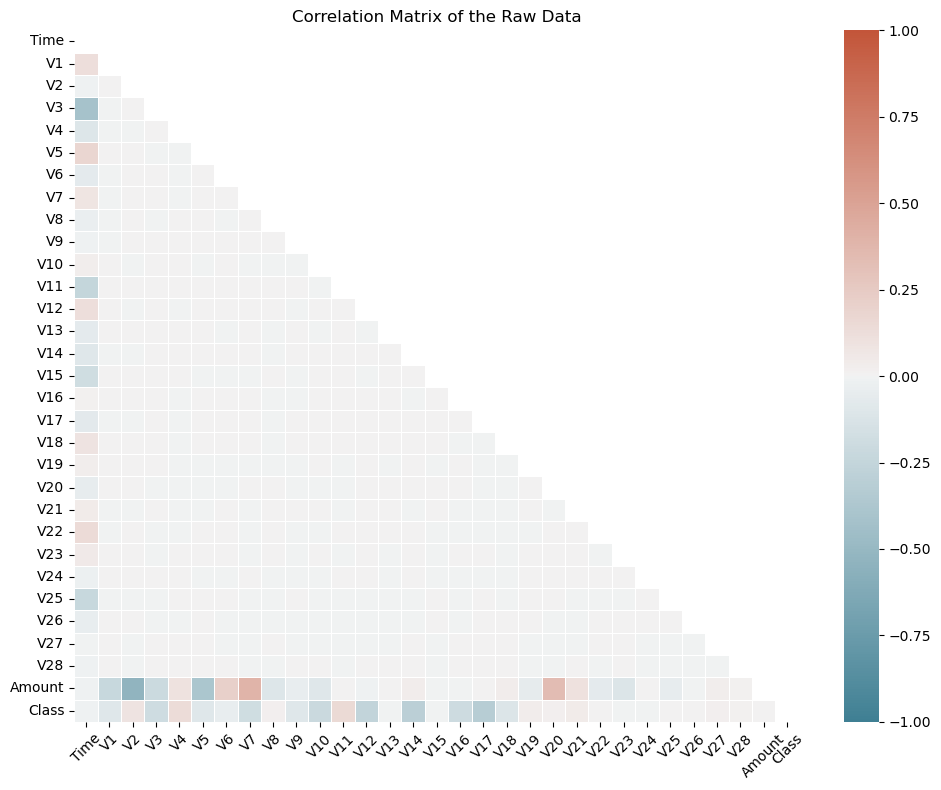

In [18]:

# Compute the correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Define a custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create a correlation heatmap without annotations
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=False, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, cbar=True)

# Customize the plot
plt.title("Correlation Matrix of the Raw Data")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()




In [10]:
#! pip install skimpy # < -- uncomment to install from PyPI 
from skimpy import skim
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 284807 │ │ float64     │ 30    │                                                          │
│ │ Number of columns │ 31     │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean       ┃ sd     ┃ p0    ┃ p25     ┃ p50      ┃ p75     ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Time          │   0 │     0 │      95000 │  47000 │     0 │   54000 │    85000 │  140000 │ 170000 │ ▂▇▇▂▇▇ │  │
│ │ V1            │   0 │     0 │    1.2e-15 │      2 │   -56 │   -0.92 │    0.018 │     1.3 │    2.5 │      ▇ │  │
│ │ V2            │   0 │     0 │    3.4e-16 │    1.7 │   -73 │    -0.6 │    0.065 │     0.8 │     22 │     ▇  │  │
│ │ V3            │   0 │     0 │   -1.4e-15 │    1.5 │   -48 │   -0.89 │     0.18 │       1 │    9.4 │     ▅▇ │  │
│ │ V4            │   0 │     0 │    2.1e-15 │    1.4 │  -5.7 │   -0.85 │    -0.02 │    0.74 │     17 │  ▁▇▁   │  │
│ │ V5            │   0 │     0 │    9.6e-16 │    1.4 │  -110 │   -0.69 │   -0.054 │    0.61 │     35 │     ▇  │  │
│ │ V6            │   0 │     0 │    1.5e-15 │    1.3 │   -26 │   -0.77 │    -0.27 │     0.4 │     73 │    ▇   │  │
│ │ V7            │   0 │     0 │   -5.6e-16 │    1.2 │   -44 │   -0.55 │     0.04 │    0.57 │    120 │    ▇   │  │
│ │ V8            │   0 │     0 │    1.2e-16 │    1.2 │   -73 │   -0.21 │    0.022 │    0.33 │     20 │     ▇  │  │
│ │ V9            │   0 │     0 │   -2.4e-15 │    1.1 │   -13 │   -0.64 │   -0.051 │     0.6 │     16 │    ▇▁  │  │
│ │ V10           │   0 │     0 │    2.2e-15 │    1.1 │   -25 │   -0.54 │   -0.093 │    0.45 │     24 │    ▃▇  │  │
│ │ V11           │   0 │     0 │    1.7e-15 │      1 │  -4.8 │   -0.76 │   -0.033 │    0.74 │     12 │   ▇▂   │  │
│ │ V12           │   0 │     0 │   -1.2e-15 │      1 │   -19 │   -0.41 │     0.14 │    0.62 │    7.8 │    ▁▇  │  │
│ │ V13           │   0 │     0 │    8.2e-16 │      1 │  -5.8 │   -0.65 │   -0.014 │    0.66 │    7.1 │   ▁▇▃  │  │
│ │ V14           │   0 │     0 │    1.2e-15 │   0.96 │   -19 │   -0.43 │    0.051 │    0.49 │     11 │    ▇▂  │  │
│ │ V15           │   0 │     0 │    4.9e-15 │   0.92 │  -4.5 │   -0.58 │    0.048 │    0.65 │    8.9 │   ▇▇   │  │
│ │ V16           │   0 │     0 │    1.4e-15 │   0.88 │   -14 │   -0.47 │    0.066 │    0.52 │     17 │    ▇   │  │
│ │ V17           │   0 │     0 │   -3.8e-16 │   0.85 │   -25 │   -0.48 │   -0.066 │     0.4 │    9.3 │     ▇  │  │
│ │ V18           │   0 │     0 │    9.6e-16 │   0.84 │  -9.5 │    -0.5 │  -0.0036 │     0.5 │      5 │    ▇▅  │  │
│ │ V19           │   0 │     0 │      1e-15 │   0.81 │  -7.2 │   -0.46 │   0.0037 │    0.46 │    5.6 │    ▁▇  │  │
│ │ V20           │   0 │     0 │    6.4e-16 │   0.77 │   -54 │   -0.21 │   -0.062 │    0.13 │     39 │     ▇  │  │
│ │ V21           │   0 │     0 │    1.7e-16 │   0.73 │   -35 │   -0.23 │   -0.029 │    0.19 │     27 │     ▇  │  │
│ │ V22           │   0 │     0 │   -3.6e-16 │   0.73 │ 

## Exercise
How expressive is Fraud in this dataset ? Calculate both the number and proportion of Fraud in the training and testing sets. 

## KNN Model Building and Prediction

In [14]:
# Data Preprocessing
# Standardize the 'Amount' column, as other features are already standardized
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Split the data into features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the K-NN model
k = 5  # You can adjust the value of k
KNN = KNeighborsClassifier()
KNN_param = {'n_neighbors': np.arange(2,3), # < -- n_neighbors: the number of neighbours to use
             'p': [1,2], # <-- p: euclidean distance (p=2), manhattan distance (p=1)
             'weights': ['uniform','distance']} # < -- weights: whether to weight the neighbours uniformly or to the inverse of the distance
KNN_cv = GridSearchCV(estimator=KNN, param_grid=KNN_param , scoring='accuracy', cv=5)
KNN_cv.fit(X_train, y_train)
KNN_cv.best_params_

{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}

In [15]:
#cross-validation
KNN_best = KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')
cv_results = cross_validate(KNN_best, X_train, y_train, scoring='accuracy', cv=5)
cv_results['test_score'].mean()


0.9986105816998263

In [17]:
# Make predictions
y_pred = KNN_cv.predict(X_test.values) # <-- watch out for this: Knn assumes X is an numpy array in older versions of sklearn

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')


c:\Users\Miguel\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9989466661985184
Confusion Matrix:
[[85297    10]
 [   80    56]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.85      0.41      0.55       136

    accuracy                           1.00     85443
   macro avg       0.92      0.71      0.78     85443
weighted avg       1.00      1.00      1.00     85443



## Exercise

Perform a grid-search by enlarging the number of neighbors and find the best configuration for your model. Recompute the classification report and comment on improvements gained. 

## Bayes Classifier

The Bayes Classifier, often referred to as the Naive Bayes Classifier, is a simple but powerful probabilistic classification algorithm. It's based on Bayes' theorem and is widely used in machine learning and natural language processing for various classification tasks, including text classification, spam detection, and sentiment analysis.

### Naive Bayes Assumption
The "naive" in Naive Bayes comes from the simplifying assumption that features (attributes) used for classification are conditionally independent given the class label. In other words, it assumes that the presence or absence of one feature does not affect the presence or absence of another feature. This simplification makes the math easier and is why it's called "naive."

### How the Bayes Classifier Works

1. **Data Preparation**
   - Collect a labeled dataset, where each instance is associated with a class label.
   - Preprocess the data and extract features relevant to the classification task.

2. **Training**
   - Setup a class priors: $P(y)$ for each class y, which represents the probability of each class occurring in the dataset.
   - For each feature, calculate conditional probabilities $P(X_i|y)$ for each class y. This represents the probability of observing feature X_i given that the class is y.

3. **Prediction**
   - Given a new data point with features X, calculate the probability of it belonging to each class y using Bayes' theorem and the naive independence assumption:
     $$
     P(y|X) = P(y) P(X_1|y) P(X_2|y) ... P(X_N|y)
     $$
   - The class with the highest posterior probability is the predicted class.

### Types of Naive Bayes Classifiers

There are several variants of the Naive Bayes Classifier, each of which makes different assumptions about the distribution of data. The most common ones include:

1. **Gaussian Naive Bayes**
   - Assumes that the features follow a Gaussian (normal) distribution. 

2. **Multinomial Naive Bayes**
   - Used for discrete data like text, where features are counts of words or terms. It's commonly used in text classification tasks.

3. **Bernoulli Naive Bayes**
   - Appropriate for binary data, where features are either 0 or 1. It's commonly used in spam detection.

### Advantages of the Bayes Classifier

- Simple and computationally efficient.
- Works well with high-dimensional data.
- Performs surprisingly well in many real-world applications, especially text classification.

### Limitations of the Bayes Classifier

- The "naive" assumption of feature independence may not hold in some real-world data.
- It can struggle with rare or unseen features.
- Performance can degrade if the feature space is highly imbalanced.
- Doesn't handle numerical features with complex distributions well.

In practice, the Bayes Classifier is a good choice for quick and effective classification tasks, especially when working with text data, and it often serves as a strong baseline model for many machine learning projects.

One of the bottlenecks we came across while using KNN is computing time. This problem gets much worse with greater volumes of data. Let's see how the Bayes classifier performs and compare.





In [23]:
from sklearn.naive_bayes import GaussianNB
# Choose the appropriate Naive Bayes variant (e.g., Gaussian Naive Bayes)
model = GaussianNB()

model.fit(X_train, y_train)

# Model Prediction
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')
print(f'Confusion Matrix:\n{confusion}')

# Use a ROC curve


Accuracy: 0.9928841449855459
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.14      0.66      0.23       136

    accuracy                           0.99     85443
   macro avg       0.57      0.83      0.61     85443
weighted avg       1.00      0.99      1.00     85443

Confusion Matrix:
[[84745   562]
 [   46    90]]


## Receiver Operating Characteristic (ROC) curve

The ROC curve is a graphical representation of the classifier's ability to distinguish between positive and negative classes by varying the classification threshold. Let's calculate it for our Naive Bayes Classifier of Credit Card Fraud

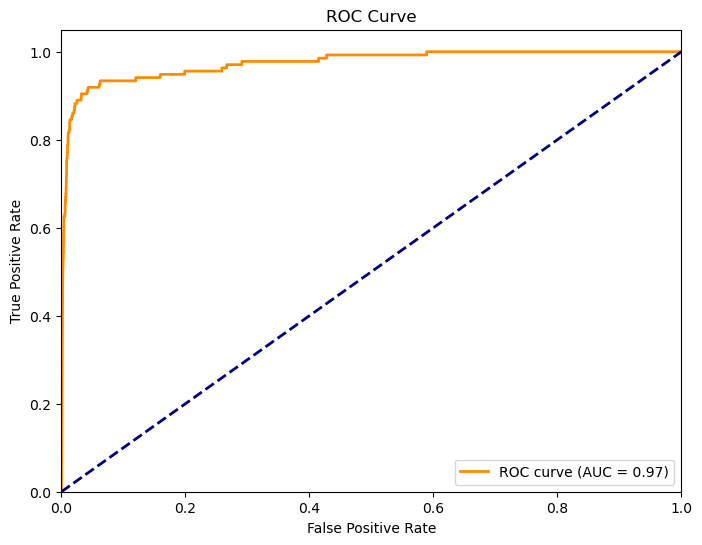

ROC AUC Score: 0.97


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Model Prediction
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class (class 1)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Model Evaluation
# You can also calculate the ROC AUC score as a numerical measure of classifier performance.
roc_auc_score = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc_score:.2f}')


The AUC (i.e. area under the curve) is a measure of the classifiers performance. A higher AUC indicates better model performance.

## Exercise
Calculate the ROC and AUC for KNN and compare with the Bayes Classifier.